## Hadamard Random Forest (HRF)

In this tutorial, we will go over the basic usage of HRF and run it on noisy simulators.
Given a $n$-qubit real valued quantum state 
$$
\ket{\psi} = U_{\text{prep.}} |0\rangle^{\otimes n} = \sum_{j=0}^{2^n-1} \psi_j\ket{j},
\tag{1}
$$ 
where $U_{\text{prep.}}$ is the unitary corresponding to the state preparation circuit and $\psi_j=\text{sgn}(\psi_j)\cdot|\psi_j| \in \mathbb{R}$. The HRF method efficiently reconstructs the corresponding state vector by sampling $n+1$ circuits. $n$ circuits each attached with one Hadamard gate at the end to superpose the amplitudes and $1$ for amplitudes $|\psi_j|$.

Applying a Hadamard gate on the $(n-k-1)$-th qubit (ordering from top to down side of the quantum circuit) and sampling the output leads to a new amplitude vector $\ket{\psi^k}$, where the amplitudes $\psi^k_{j}$ and $ \psi^k_{j+2^k}$ contain the superposition of original amplitudes as
$$
\psi^k_{j, j+2^k} = \frac{1}{\sqrt{2}}\left(\psi_j \pm \psi_{j+2^k}\right).
\tag{2}
$$

Then, one can determine the relative signs between two amplitudes $\textnormal{sgn}_{j,j+2^k} = \textnormal{sign}(\psi_j \psi_{j+2^k})$ by querying the ancillary sampling results $\{|\psi^k_j|^2\}_{k=0}^{n-1}$ 
$$
\textnormal{sgn}_{j,j+2^k} = \textnormal{sgn} {\bigg[}\underbrace{2|\psi^k_j|^2}_{\text{new prob.}} - \underbrace{|\psi_j|^2 - |\psi_{j+2^k}|^2}_\text{original prob.}{\bigg]}.
\tag{3}
$$

### Setup the noisy simulator

In [1]:
%%capture
from qiskit_ibm_runtime import QiskitRuntimeService

# Get a real backend from the runtime service
service = QiskitRuntimeService()

device = service.backend('ibm_fez')

In [2]:
from qiskit_aer import AerSimulator

backend_sim = AerSimulator.from_backend(device)

If you don't have access to the hardware, please use the following fake backend that mimics the real hardware with past calibration data.

In [3]:
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeFez

backend_sim = AerSimulator.from_backend(FakeFez())

### Circuit construction $U_{\text{prep.}}$

In this tutorial, we will use the `RealAmplitudes` ansatz that consists of layers of $R_y$ rotation gates and adjacent CNOT gates.

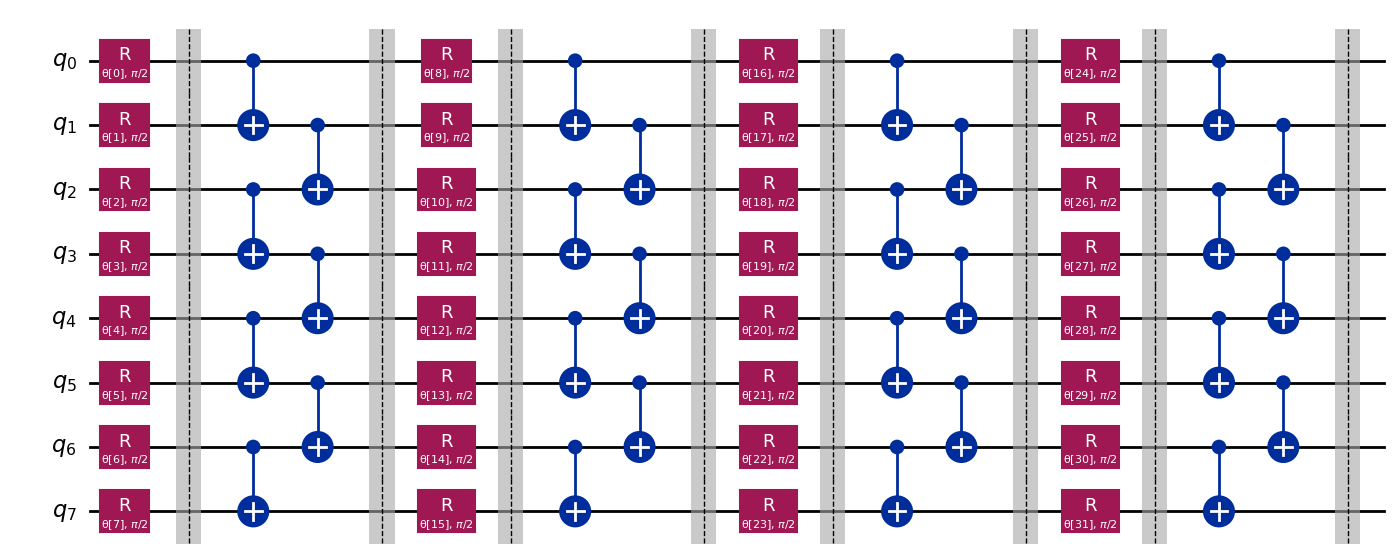

In [5]:
from qiskit.circuit.library import real_amplitudes

num_qubits = 8
num_layers = 4
ansatz = real_amplitudes(num_qubits, entanglement='pairwise', reps=num_layers, insert_barriers=True, skip_final_rotation_layer=True)
ansatz.decompose().draw("mpl", fold=-1)

### Generate $n+1$ circuits

In [6]:
import hadamard_random_forest as hrf

list_circuits = hrf.get_circuits(num_qubits, ansatz)

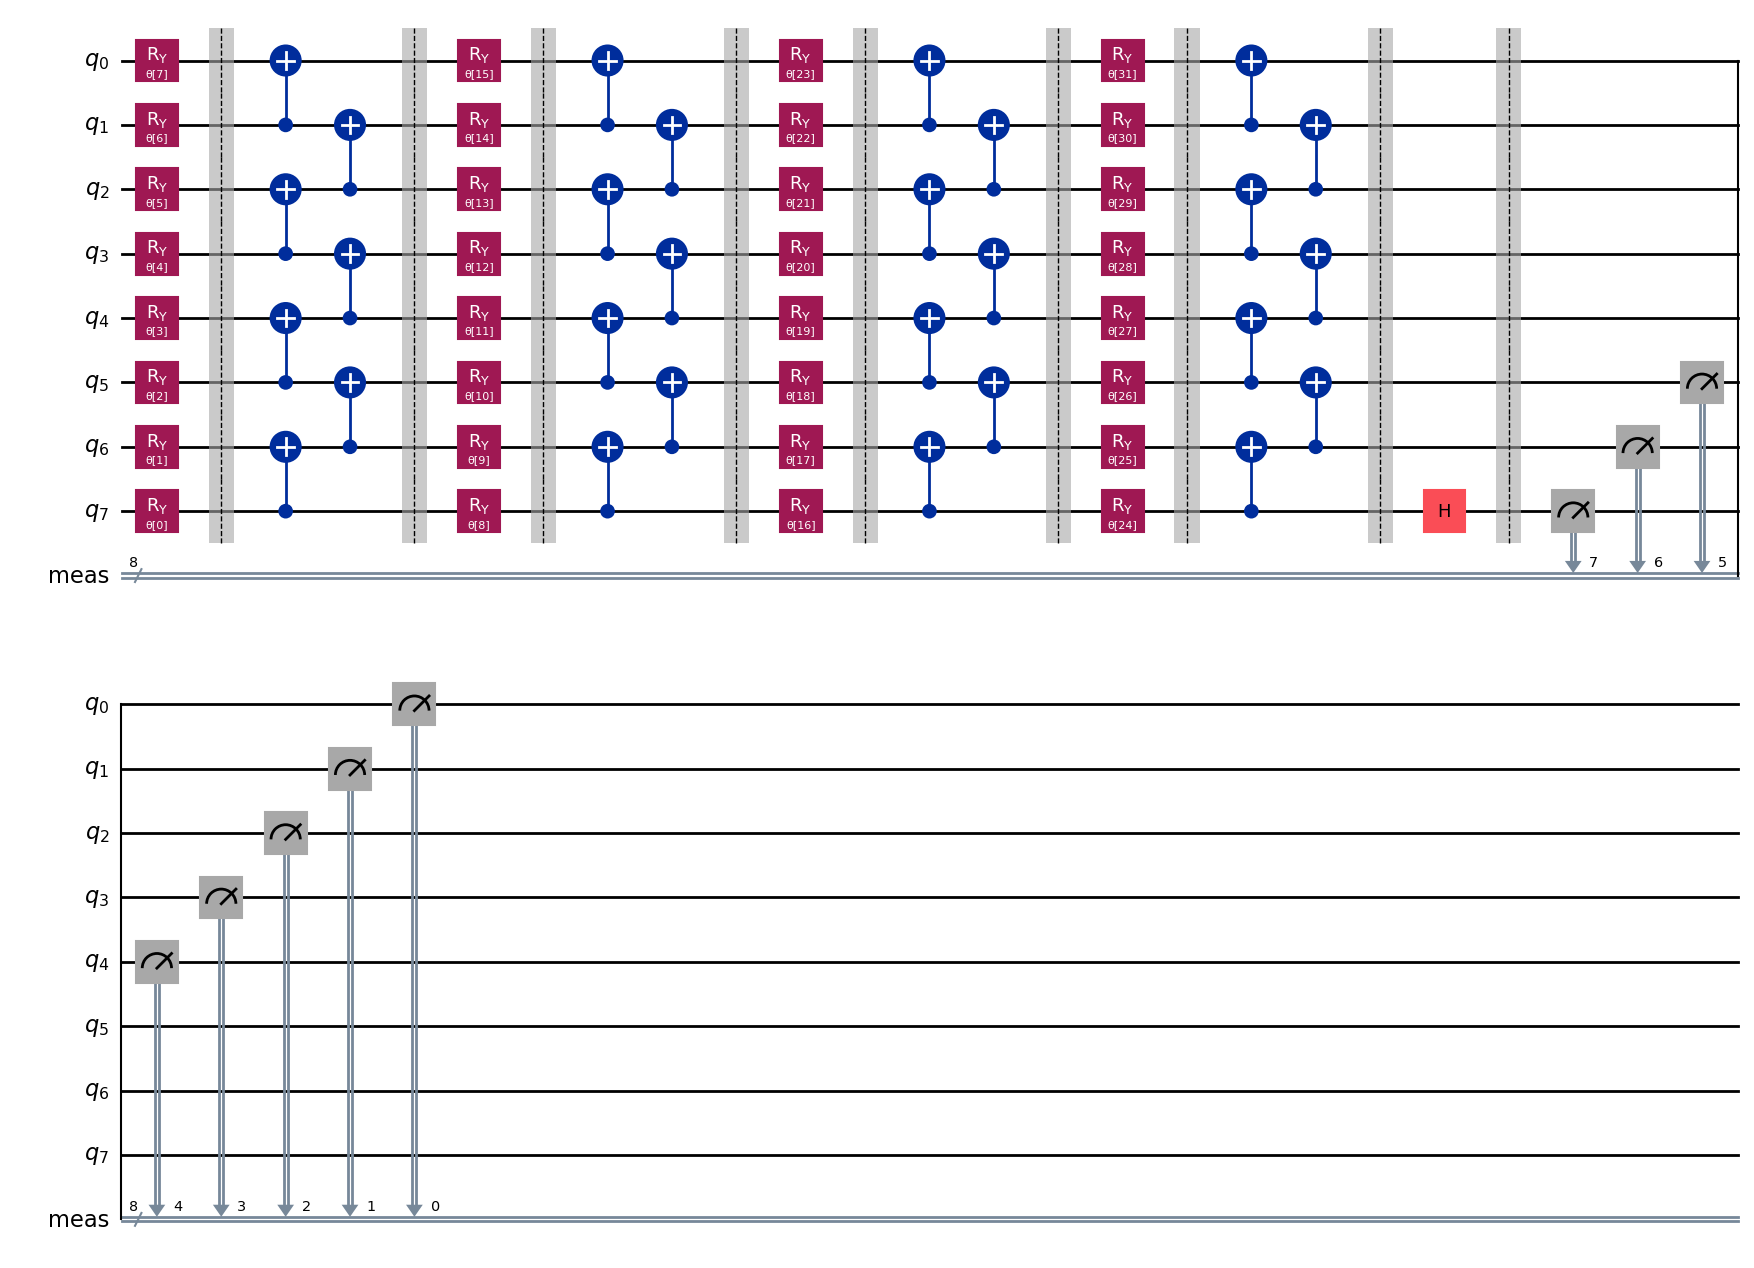

In [7]:
list_circuits[1].reverse_bits().draw("mpl")

### Collect sampling results

Collect the ancillary sampling results $\{|\psi^k_j|^2\}_{k=0}^{n-1}$ and amplitudes $\{|\psi_j|^2\}$.

In [8]:
import dill as pickle

# Load pre-generated parameters
with open('params.pkl', 'rb') as f:
    loaded_param = pickle.load(f)

In [9]:
# Set number of experiment shots
shots = 100000

# Set parameters
params = loaded_param['parameter'][(num_qubits, num_layers)][0]  # contains 5 groups of parameters

# Collect samples
samples = hrf.get_samples_noisy(num_qubits, list_circuits, shots, params, backend_sim, error_mitigation=True)

Similar to quantum state tomography experiments, the measurement error mitigation is realized through `mthree` calibrations. Read [here](https://qiskit.github.io/qiskit-addon-mthree/) for more details.

### Reconstruct the state

Once we have sampled the $n+1$ circuits, we will use `samples[0]` to reconstrcut the amplitudes $|\psi_j|$ and `samples[1],...,samples[n]` to determine the signs of each amplitude $\text{sgn}(\psi_j)$. The sign determination is done thorugh a majority voting among many random decision trees (a random forest). One can use `save_tree=True` to save and visualize the trees, where blue nodes stands for $\text{sgn}(\psi_j)=+1$ and orange nodes stands for $\text{sgn}(\psi_j)=-1$. 

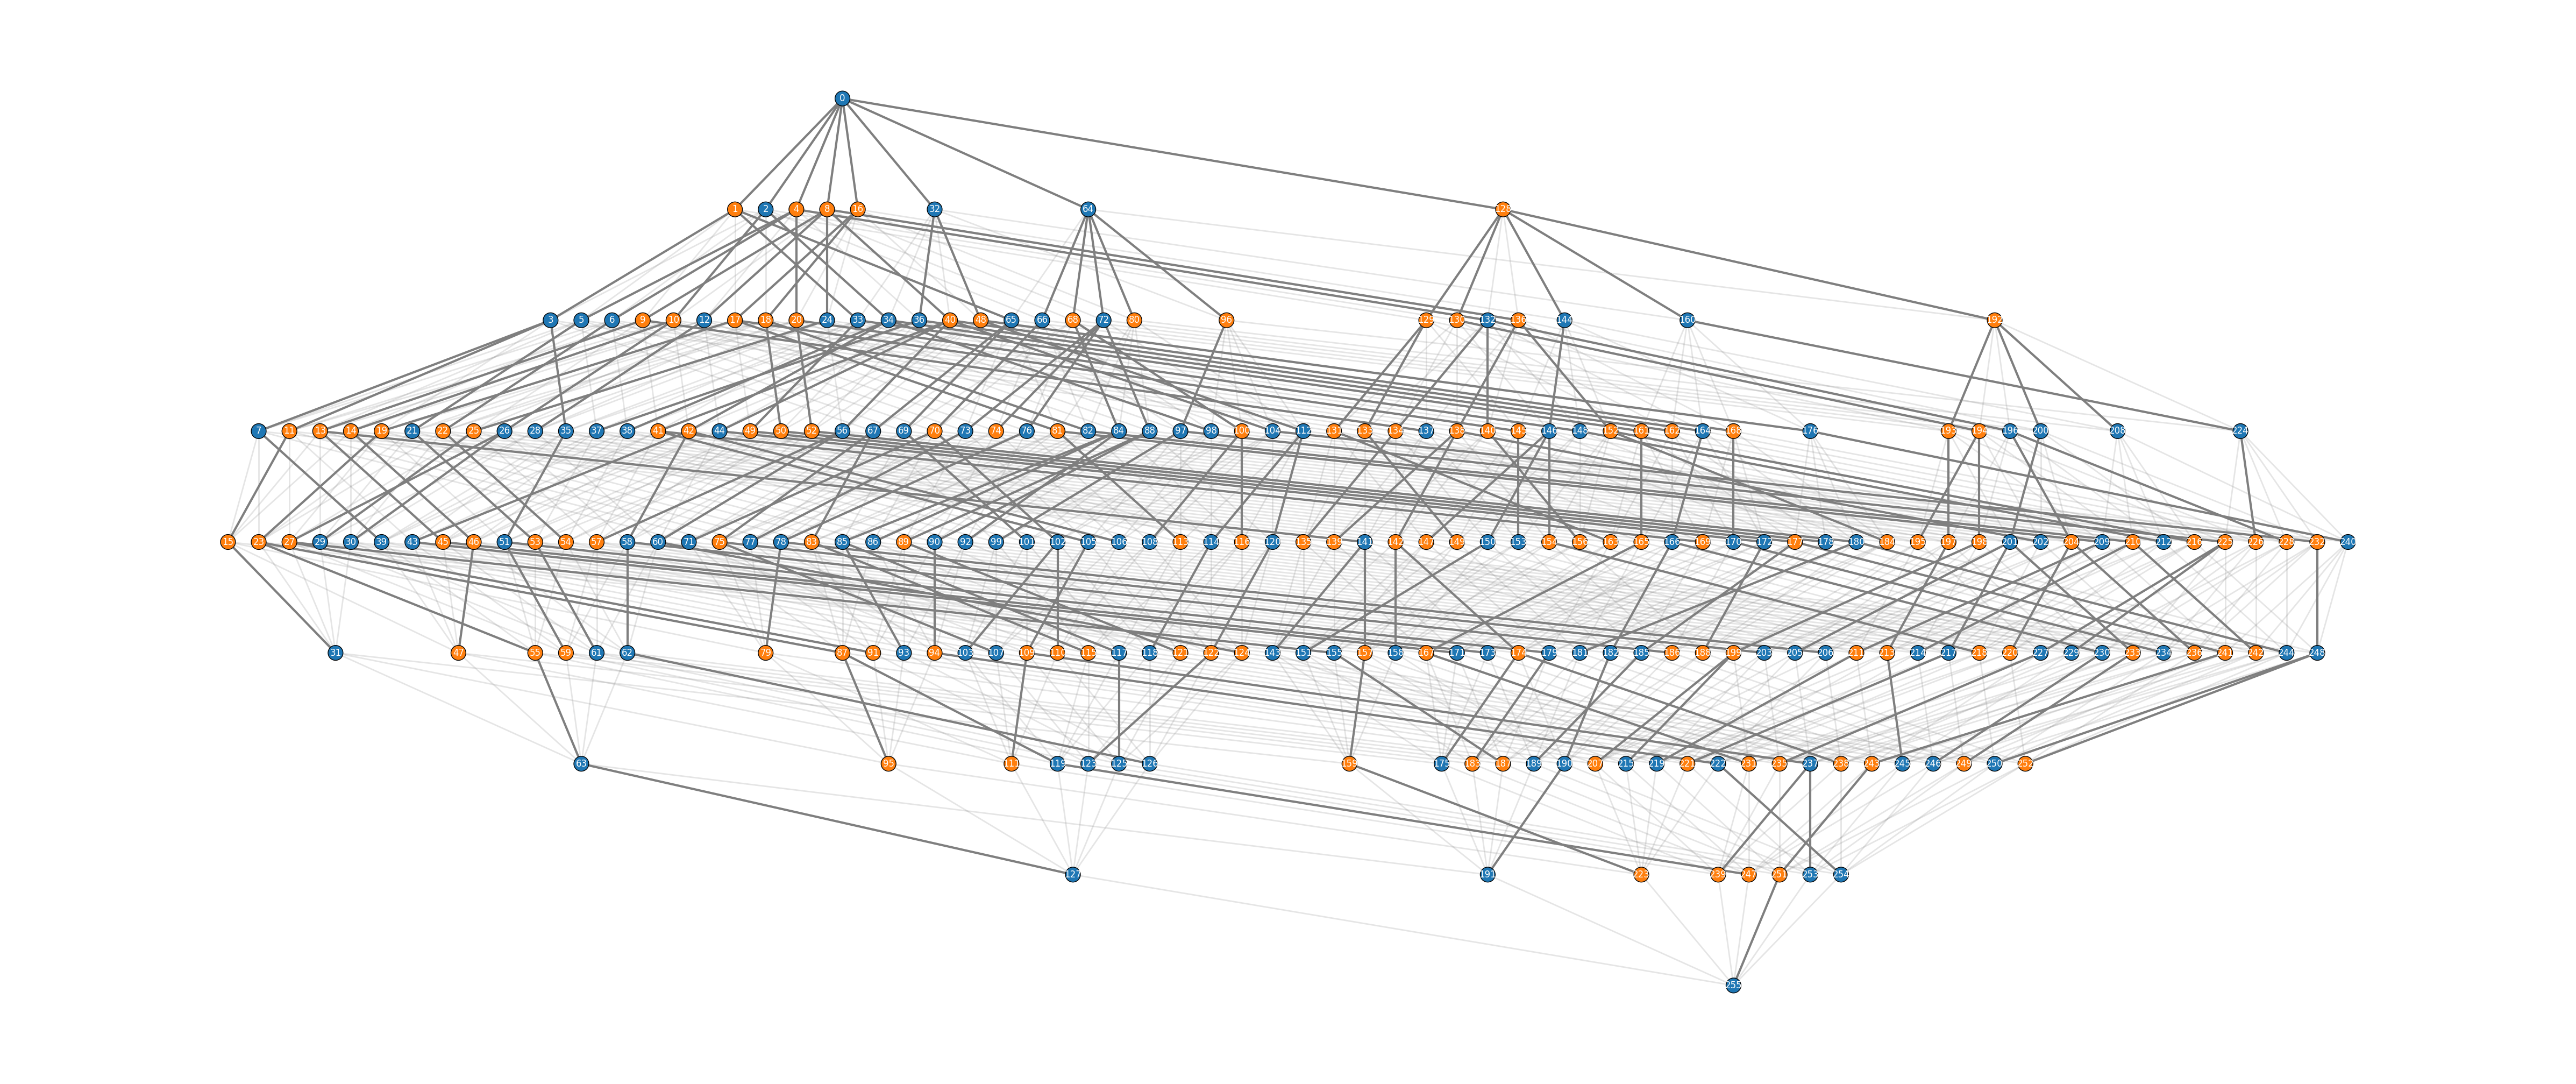

In [10]:
# Set number of decision trees for majority voting
num_trees = 111

# Fix random seed
hrf.fix_random_seed(999)

# Reconstruct the satatevector
statevector_approx = hrf.get_statevector(num_qubits, num_trees, samples, save_tree=True, show_tree=True)

In [11]:
from qiskit.quantum_info import Statevector, state_fidelity

# Evaluate circuit and recover the exact statevector
ansatz.assign_parameters(params, inplace=True)
statevector = Statevector(ansatz)

In [12]:
import numpy as np
    
fid = state_fidelity(statevector_approx, statevector)
print("HRF Fidelity:", fid)
print("Fidelity Upper Bound (no sign errors):", state_fidelity(np.abs(statevector_approx), np.abs(statevector)))

HRF Fidelity: 0.9827444162523152
Fidelity Upper Bound (no sign errors): 0.9867632099054602


### Runtime scaling

**Note:** The following code block might take 10 minutes.

In [14]:
import time
import random
import pandas as pd
import numpy as np
from itertools import product
from tqdm.auto import tqdm

shots = 100000
max_qubits = 8
num_layers = 4
num_trees = 111
repetitions = 3

# Collect data [num_qubits, trial, runtime_s, fidelity]
data = []
total_runs = 4 * repetitions


hrf.fix_random_seed(999)
for num_qubits, trial in tqdm(
    product(range(2, max_qubits+1, 2), range(0, repetitions)),
    total=total_runs,
    desc="HRF Runs"
):
    # 1) Build ansatz
    ansatz = real_amplitudes(num_qubits, entanglement='pairwise', reps=num_layers, skip_final_rotation_layer=True)
    params = loaded_param['parameter'][(num_qubits, num_layers)][trial]

    # 2) Set up the experiment
    list_circuits = hrf.get_circuits(num_qubits, ansatz)

    # 3) Time the run 
    t0 = time.time()
    samples = hrf.get_samples_noisy(num_qubits, list_circuits, shots, params, backend_sim, error_mitigation=True)
    statevector_approx = hrf.get_statevector(num_qubits, num_trees, samples, save_tree=False, show_tree=False)
    runtime = time.time() - t0

    # 4) Extract the fidelity result
    ansatz.assign_parameters(params, inplace=True)
    statevector = Statevector(ansatz)
    fidelity = state_fidelity(statevector_approx, statevector)

    # 5) Record data
    data.append({
        "num_qubits": num_qubits,
        "trial": trial+1,
        "runtime": runtime,
        "fidelity": fidelity
    })

/Users/jacksong/Documents/GitHub/Quantum-HRF-Tomography/qenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
HRF Runs: 100%|██████████| 12/12 [02:49<00:00, 14.16s/it]


In [15]:
# Turn into a DataFrame for easy plotting/analysis
results_df = pd.DataFrame(data)
results_df

,num_qubits,trial,runtime,fidelity
0,2,1,8.369630,0.999116
1,2,2,7.720807,0.999270
2,2,3,8.908692,0.998573
3,4,1,11.474902,0.993500
4,4,2,12.582380,0.994029
5,4,3,12.095767,0.997377
6,6,1,15.799392,0.994325
7,6,2,15.086541,0.982004
8,6,3,16.008589,0.988756
9,8,1,20.479997,0.982401


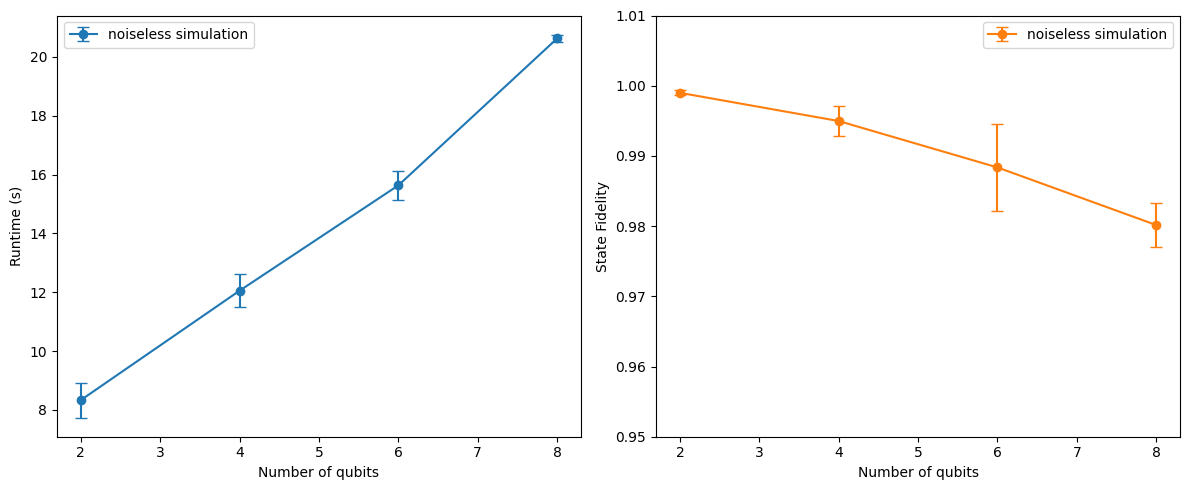

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 1) Aggregate data by qubit count 
# assume results_df has columns: num_qubits, trial, runtime, fidelity
grp = results_df.groupby('num_qubits').agg(
    runtime_mean=('runtime','mean'),
    runtime_std =('runtime','std'),
    fidelity_mean=('fidelity','mean'),
    fidelity_std =('fidelity','std'),
)
x = grp.index.values            # array([1,2,3,4,5])

rt_mean = grp['runtime_mean'].values
rt_err  = grp['runtime_std'].values
fid_mean = grp['fidelity_mean'].values
fid_err  = grp['fidelity_std'].values

# 2) Plot 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
xticks = [1,2,3,4,5,6,7,8]
ax1.set_xticks(xticks)
ax2.set_xticks(xticks)

# Runtime subplot
ax1.errorbar(x, rt_mean, yerr=rt_err, fmt='o-', color="tab:blue", capsize=4, label='noiseless simulation')
ax1.set_xlabel('Number of qubits')
ax1.set_ylabel('Runtime (s)')
ax1.legend()

# Fidelity subplot
ax2.errorbar(x, fid_mean, yerr=fid_err, fmt='o-', color="tab:orange", capsize=4, label='noiseless simulation')
ax2.set_xlabel('Number of qubits')
ax2.set_ylabel('State Fidelity')
ax2.set_ylim([0.95,1.01])
ax2.legend()

plt.tight_layout()
plt.show()

---

## Software info

In [17]:
import qiskit
import qiskit_aer
import qiskit_ibm_runtime
import mthree

print(f'Qiskit: {qiskit.__version__}')
print(f'Qiskit Aer: {qiskit_aer.__version__}')
print(f'Qiskit IBM Runtime: {qiskit_ibm_runtime.__version__}')
print(f'Mthree error mitigation: {mthree.__version__}')

Qiskit: 2.1.2
Qiskit Aer: 0.17.1
Qiskit IBM Runtime: 0.41.1
Mthree error mitigation: 3.0.0
